<a href="https://colab.research.google.com/github/Poohi5/CMPE297/blob/master/Assignment_4/MultiTaskLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi Task Learning

## In this colab, I am referring to [Facial Landmark Detection by Deep Multi-task Learning](http://mmlab.ie.cuhk.edu.hk/projects/TCDCN.html) paper to perform Multi task learning for determine facial landmark localize a series of landmarks, i.e., points of interest on the image (nose, left eye, mouth), and tags, including the age and gender of the person 

In [1]:
!pip install tqdm requests --upgrade

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.51.0)
Requirement already up-to-date: requests in /usr/local/lib/python3.6/dist-packages (2.24.0)


### Import Data

In [2]:
from tqdm import tqdm
import requests

url = "http://mmlab.ie.cuhk.edu.hk/projects/TCDCN/data/MTFL.zip"
response = requests.get(url, stream=True)

with open("MTFL", "wb") as handle:
    for data in tqdm(response.iter_content(), unit=' KB'):
        handle.write(data)

150152960 KB [15:33, 160898.21 KB/s]


### Unzipping data

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('MTFL', 'r')
zip_ref.extractall()
zip_ref.close()

### Loading the dataset.

##### Loading the text files using pandas

In [4]:
import pandas as pd
train_data = pd.read_csv('training.txt', sep=' ', header=None, skipinitialspace=True, nrows=10000)
test_data = pd.read_csv('testing.txt', sep=' ', header=None, skipinitialspace=True, nrows=2995)

##### Lets look at the first row

In [5]:
train_data.iloc[0]

0     lfw_5590\Aaron_Eckhart_0001.jpg
1                              107.25
2                              147.75
3                              126.25
4                              106.25
5                              140.75
6                              108.75
7                              113.25
8                              143.75
9                              158.75
10                             162.75
11                                  1
12                                  2
13                                  2
14                                  3
Name: 0, dtype: object

In [6]:
train_data.iloc[:, 0] = train_data.iloc[:, 0].apply(lambda s: s.replace('\\', '/')) # Needed for filename convention
test_data.iloc[:, 0] = test_data.iloc[:, 0].apply(lambda s: s.replace('\\', '/')) # Needed for filename convention

##### Loading the data using tf.data and tf.image

In [7]:
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [8]:
# Example code for handling datasets
import matplotlib.pyplot as plt

# Load filenames and labels
filenames = tf.constant(train_data.iloc[:, 0].tolist())
labels = tf.constant(train_data.iloc[:, 1:].values)

# Add to a dataset object
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# We can debug using eager execution
for img, labels in dataset.batch(4).take(1):
  print(img)
  print(labels)

Instructions for updating:
Colocations handled automatically by placer.
tf.Tensor(
[b'lfw_5590/Aaron_Eckhart_0001.jpg' b'lfw_5590/Aaron_Guiel_0001.jpg'
 b'lfw_5590/Aaron_Peirsol_0001.jpg' b'lfw_5590/Aaron_Pena_0001.jpg'], shape=(4,), dtype=string)
tf.Tensor(
[[107.25 147.75 126.25 106.25 140.75 108.75 113.25 143.75 158.75 162.75
    1.     2.     2.     3.  ]
 [101.25 146.75 125.25  93.75 139.75 112.25 117.75 137.75 160.75 164.75
    1.     1.     2.     3.  ]
 [107.75 147.75 130.25 109.25 147.75 114.25 114.25 140.75 154.25 153.75
    1.     1.     2.     3.  ]
 [102.75 146.25 126.25 120.75 147.25 117.75 104.75 137.75 164.75 156.75
    1.     2.     2.     3.  ]], shape=(4, 14), dtype=float64)


### The ‘channels’ parameter allows to load both colour and b/w images in a single line; we resize all images to our desired format (40x40, in accordance with the original paper); on line 8, we also normalize our landmark labels to denote a relative location between 0 and 1, instead of an absolute one (since we resized all images, and images might come with different shapes)

In [9]:
def _parse_function(filename, label):
  image_string = tf.read_file(filename) 
  image_decoded = tf.image.decode_jpeg(image_string, channels=3) # Channels needed because some test images are b/w
  image_resized = tf.image.resize_images(image_decoded, [40, 40])
  image_shape = tf.cast(tf.shape(image_decoded), tf.float32)
  label = tf.concat([label[0:5] / image_shape[0], label[5:10] / image_shape[1], label[10:]], axis=0)
  return {"x": image_resized}, label

In [10]:
# This snippet is adapted from here: https://www.tensorflow.org/guide/datasets
def input_fn(dataframe, is_eval=False):

  # Load the list of files
  filenames = tf.constant(dataframe.iloc[:, 0].tolist())

  # Load the labels
  labels = tf.constant(dataframe.iloc[:, 1:].values.astype(np.float32))

  # Build the dataset with image processing on top of it
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(_parse_function)

  # Add shuffling and repeatition if training
  if is_eval:
    dataset = dataset.batch(64)
  else:
    dataset = dataset.repeat().shuffle(1000).batch(64)
  
  return dataset

tf.Tensor(
[0.429 0.591 0.505 0.425 0.563 0.435 0.453 0.575 0.635 0.651 1.    2.
 2.    3.   ], shape=(14,), dtype=float32)


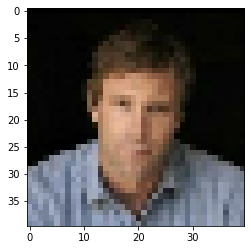

In [11]:
import matplotlib.pyplot as plt
for (imgs, labels) in input_fn(train_data, is_eval=True).take(1):
  plt.imshow(imgs['x'][0] / 255)
  print(labels[0])

### building a CNN with custom estimator

In [12]:
# Reimplement the feature extraction from the original paper
def extract_features(features):
  # Input layer
  input_layer = tf.reshape(features["x"], [-1, 40, 40, 3])

  # First convolutive layer
  conv1 = tf.layers.conv2d(inputs=input_layer, filters=16, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Second convolutive layer
  conv2 = tf.layers.conv2d(inputs=pool1, filters=48, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
  
  # Third convolutive layer
  conv3 = tf.layers.conv2d(inputs=pool2, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
  pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
  
  # Fourth convolutive layer
  conv4 = tf.layers.conv2d(inputs=pool3, filters=64, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)
  
  # Dense Layer
  flat = tf.reshape(conv4, [-1, 5 * 5 * 64])
  dense = tf.layers.dense(inputs=flat, units=100, activation=tf.nn.relu)
  
  return dense

#### Single task 

In [13]:
def single_task_cnn_model_fn(features, labels, mode):
  
  # Get features
  dense = extract_features(features)
  
  # Make predictions
  predictions = tf.layers.dense(inputs=dense, units=2)

  outputs = {
      "predictions": predictions
  }

  # We just want the predictions
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=outputs)

  # If not in mode.PREDICT, compute the loss (mean squared error)
  loss = tf.losses.mean_squared_error(labels=labels[:, 2:8:5], predictions=predictions)

  # Single optimization step
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # If not PREDICT or TRAIN, then we are evaluating the model
  eval_metric_ops = {
      "rmse": tf.metrics.root_mean_squared_error(
          labels=labels[:, 2:8:5], predictions=outputs["predictions"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [14]:
single_task_classifier = tf.estimator.Estimator(
    model_fn=single_task_cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpd_pppd3w', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fab32ed5e10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train the model

In [15]:
single_task_classifier.train(input_fn=lambda: input_fn(train_data), steps=2000)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpd_pppd3w/model.ckpt.
INFO:tensorflow:loss = 138.92953, step = 1
INFO:tensorflow:global_step/sec: 4.23519
INFO:tensorflow:loss = 0.1641745, step = 101 (23.614 sec)
INFO:tensorflow:global_step/sec: 4.5172
INFO:tensorflow:loss = 0.122994274, step = 201 (22.140 sec)
INFO:tensorflow:global_step/sec: 4.25318
INFO:tensorflow:loss = 0.09741178, step = 301 (23.510 sec)
INFO:tensorflow:global_step/sec: 4.26968
INFO:tensorflow:loss = 0.058827132, step = 401 (23.423 sec)
INFO:tensor

#### Evaluate model

In [16]:
single_task_classifier.evaluate(input_fn=lambda: input_fn(test_data, is_eval=True))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-30T06:45:42Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmpd_pppd3w/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-10-30-06:45:48
INFO:tensorflow:Saving dict for global step 2000: global_step = 2000, loss = 0.013137344, rmse = 0.11459168
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpd_pppd3w/model.ckpt-2000


{'global_step': 2000, 'loss': 0.013137344, 'rmse': 0.11459168}

#### Predict

In [17]:
p = list(single_task_classifier.predict(lambda: input_fn(test_data, is_eval=True)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpd_pppd3w/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


#### Evaluate a single prediction

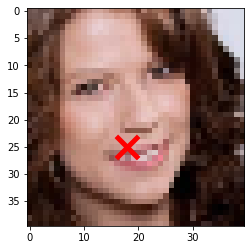

In [18]:
for imgs, _ in input_fn(test_data, is_eval=True).take(1):
  img_idx = 1
  plt.imshow(imgs["x"][img_idx] / 255)
  plt.scatter(p[img_idx]['predictions'][0] * 40, p[img_idx]['predictions'][1] * 40, 500, marker='x', color='red', linewidth=5)

In [19]:
def single_head_cnn_model_fn(features, labels, mode):
  
  dense = extract_features(features)
  
  # Predictions
  predictions = tf.layers.dense(inputs=dense, units=2)

  # Optimizer
  optimizer = tf.train.AdamOptimizer()
  
  # Define the head
  regression_head = tf.contrib.estimator.regression_head(label_dimension=2)
  return regression_head.create_estimator_spec(features, mode, predictions, labels[:, 2:8:5], optimizer)

In [20]:
# Create the Estimator
cnn_classifier = tf.estimator.Estimator(
    model_fn=single_head_cnn_model_fn, model_dir="/tmp/cnn_single_head")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/cnn_single_head', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fab32ed5c88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Multi Task Learning

In [21]:
import numpy as np
import tensorflow as tf

In [22]:
def multihead_input_fn(data, is_eval=False):
  features, labels = input_fn(data, is_eval=is_eval).make_one_shot_iterator().get_next() # Why?
  return features, {'head_nose': labels[:, 2:8:5], 'head_pose': tf.cast(labels[:, -1] - 1.0, tf.int32)}

In [23]:
def multi_head_cnn_model_fn(features, labels, mode):
  
  dense = extract_features(features)
  
  # Predictions for each task
  predictions_nose = tf.layers.dense(inputs=dense, units=2)
  predictions_pose = tf.layers.dense(inputs=dense, units=5)
  logits = {'head_nose': predictions_nose, 'head_pose': predictions_pose}
  
  # Optimizer
  optimizer = tf.train.AdamOptimizer()

  # Double head
  regression_head = tf.contrib.estimator.regression_head(name='head_nose', label_dimension=2)
  classification_head = tf.contrib.estimator.multi_class_head(name='head_pose', n_classes=5)
  
  # Multi head combining two single heads
  multi_head = tf.contrib.estimator.multi_head([regression_head, classification_head])
  
  return multi_head.create_estimator_spec(features, mode, logits, labels, optimizer)

In [24]:
# Create the Estimator
multitask_classifier = tf.estimator.Estimator(model_fn=multi_head_cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbrz03ihd', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fab4d5fa668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [25]:
# Train the model
multitask_classifier.train(input_fn=lambda: multihead_input_fn(train_data), steps=1000)

INFO:tensorflow:Calling model_fn.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpbrz03ihd/model.ckpt.
INFO:tensorflow:loss = 66.66521, step = 1
INFO:tensorflow:global_step/sec: 4.09673
INFO:tensorflow:loss = 0.9142964, step = 101 (24.415 sec)
INFO:tensorflow:global_step/sec: 4.31693
INFO:tensorflow:loss = 0.7404702, step = 201 (23.163 sec)
INFO:tensorflow:global_step/sec: 3.97559
INFO:tensorflow:loss = 1.7313597, step = 301 (25.152 sec)
INFO:tensorflow:global_step/sec: 4.18754
INFO:tensorflow:loss = 0.94862676, step = 401 (23.882 sec)
INFO:tensorfl

In [26]:
  multitask_classifier.evaluate(input_fn=lambda: multihead_input_fn(test_data, is_eval=True))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-30T06:53:23Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbrz03ihd/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-10-30-06:53:28
INFO:tensorflow:Saving dict for global step 1000: accuracy/head_pose = 0.6203673, average_loss/head_nose = 0.04183236, average_loss/head_pose = 1.1433985, global_step = 1000, label/mean/head_nose = 0.50384253, loss = 1.184652, loss/head_nose = 0.041811008, loss/head_pose = 1.1428407, prediction/mean/head_nose = 0.4672408
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpbrz03ihd/model.ckpt-1000


{'accuracy/head_pose': 0.6203673,
 'average_loss/head_nose': 0.04183236,
 'average_loss/head_pose': 1.1433985,
 'global_step': 1000,
 'label/mean/head_nose': 0.50384253,
 'loss': 1.184652,
 'loss/head_nose': 0.041811008,
 'loss/head_pose': 1.1428407,
 'prediction/mean/head_nose': 0.4672408}

In [27]:
p = list(multitask_classifier.predict(lambda: input_fn(test_data, is_eval=True)))
print(p[0])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbrz03ihd/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{('head_nose', 'predictions'): array([0.3853868 , 0.11707626], dtype=float32), ('head_pose', 'logits'): array([-1.5268826 , -0.28901222,  1.5035806 ,  0.36334077, -1.2541883 ],
      dtype=float32), ('head_pose', 'probabilities'): array([0.03022113, 0.10421038, 0.62578356, 0.20008948, 0.03969542],
      dtype=float32), ('head_pose', 'class_ids'): array([2]), ('head_pose', 'classes'): array([b'2'], dtype=object)}


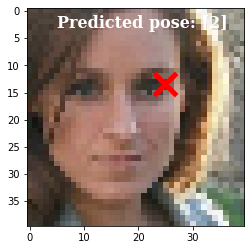

In [28]:
with tf.Session() as sess:
  imgs = sess.run(input_fn(test_data, is_eval=True).make_one_shot_iterator().get_next())
  
  font = {'family': 'serif',
        'color':  'white',
        'weight': 'bold',
        'size': 16,
        }

  img_idx = 4

  prediction_eye = p[img_idx][(('head_nose', 'predictions'))]
  prediction_pose = p[img_idx][(('head_pose', 'class_ids'))]
  
  plt.imshow(imgs[0]["x"][img_idx] / 255)
  plt.scatter(prediction_eye[0] * 40, prediction_eye[1] * 40, 500, marker='x', color='red', linewidth=5)
  plt.text(5, 3, 'Predicted pose: {}'.format(prediction_pose), fontdict=font)

**node position and pose (frontal in this case)**